In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats
import seaborn as sns
import moveSTIR as stir
import importlib 
from matplotlib.colors import TwoSlopeNorm

# Set plot properties
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

# Implementation of MoveSTIR: Simulation and theory

This notebook provides simulated examples of how MoveSTIR can be used explore individual, temporal, and spatial variation in transmission risk using movement data. The theory behind MoveSTIR is fully developed in the manuscript **Movement-driven modeling of spatio-temporal infection risk** and the accompanying supplementary material.

## Moving from movement trajectories to maximum potential infection risk

This is the example given in Figure 1 in the manuscript. Given the movement trajectories of two hosts, we build a transmission kernel and explore maximum potential infection risk along various dimensions.  Maximum potential infection risk corresponds to examining the "contact network" (as opposed to the "transmission network") in classic network terminology.

### Simulate and save movement trajectories

We use the functional movement models (FMMs) (Hooten and Johnson, 2017, *Journal of American Statistical Association* and Hooten et al. 2018, *Methods in Ecology and Evolution**) to simulate movement trajectories.  

In [3]:
# FMM parameters
tlower = 0 # Start time
tupper = 1 # End time
n = 1000 # Number of observed points
m = 850 # Number of points at which to approximate the integral. See Hooten and Johnson 2017
σ_measure = 0 # No measurement error
σ_process = .1 # White noise variability
deltat = 1 
ϕ_H = 0.01 # As sigma H goes to zero, you get Brownian motion

nvals = stir.set_discretized_values(0, 1, n)['y'] 

# Set random seed for reproducibility
rint = 61
np.random.seed(rint)
for i in range(2):
    # Simulate and save movement trajectories
    sim = stir.simulate_movement(nvals, m, σ_process, σ_measure, ϕ_H, init_position=np.array([0, 0]))
    sim.to_csv("host{0}_example_n={1}.csv".format(i + 1, n), index=False)

### Replicate Figure 1 from the main text using MoveSTIR

This code chunk does the following

1. Plots the continuous-time movement trajectories as simulated above
2. Calculates and plots the time-varying maximum force of infection and cumulative infection hazard using MoveSTIR theory (see Table 1)
3. Calculates and plots the relative contribution of direct and indirect transmission to infection risk using MoveSTIR theory (see Table 1)
4. Plots the average FOI felt by each host at specific locations over the time trajectory of movement using MoveSTIR theory (see Table 1)

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:144: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


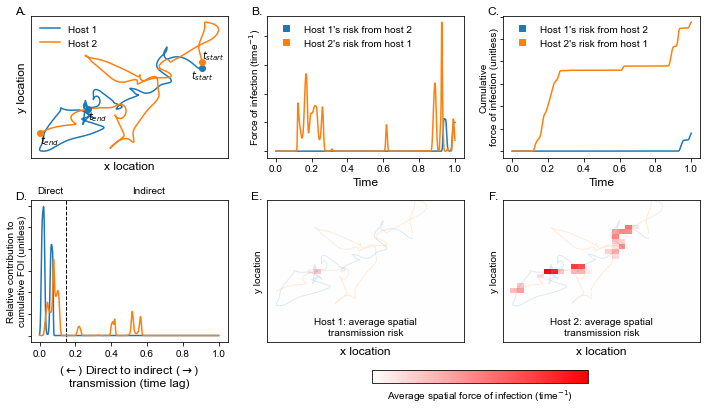

In [4]:
# Host names to extract
h1nm = "host1"
h2nm = "host2"

# Set MoveSTIR parameters
beta = 1 # Transmission rate (area per time unit)
lam = 1 # Shedding rate (per time unit)
pathogen_decay = 2 # Exponential pathogen decay rate (per time unit)
dd_type = "gaussian" # The contact function (either Gaussian or cutoff)
distance_decay = 0.1 # For gaussian this is the mean distance of the contact function.

# Some plotting variables
linestyles = ['-', '-']
linewidths = [3, 1]
nvals = np.array([1000])

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

# Load trajectories
host1 = pd.read_csv("{1}_example_n={0}.csv".format(nvals[0], h1nm))
host2 = pd.read_csv("{1}_example_n={0}.csv".format(nvals[0], h2nm))

### Plot the observed movement trajectories ###

axes[0].plot(host1.x, host1.y, label="Host 1")
axes[0].plot(host2.x, host2.y, label="Host 2")
axes[0].legend(frameon=False)

va_align = ['top', 'bottom']
ha_align = ['center', 'left']
for i, h in enumerate([host1, host2]):
    axes[0].plot([h.x.values[0]], [h.y.values[0]], 'o', color=sns.color_palette()[i])
    axes[0].text(h.x.values[0], h.y.values[0], r"$t_{start}$", ha=ha_align[i], va=va_align[i])
    axes[0].plot([h.x.values[-1]], [h.y.values[-1]], 'o', color=sns.color_palette()[i])
    axes[0].text(h.x.values[-1], h.y.values[-1], r"$t_{end}$", ha='left', va='top')

axes[0].tick_params(labelbottom=None, labelleft=None, left=None, bottom=None)
axes[0].set_xlabel("x location", size=12)
axes[0].set_ylabel("y location", size=12)

plt.subplots_adjust(wspace=0.2)

### Plot the maximum potential force of infection and cumulative hazard through time ###

time = host1.time.values
deltat = time[1] - time[0]

# Extract the transmission kernel
deltat, K_1lag2, dmat = stir.transmission_kernel(host1, host2, pathogen_decay, distance_decay, dd_type=dd_type)
deltat, K_2lag1, dmat = stir.transmission_kernel(host2, host1, pathogen_decay, distance_decay, dd_type=dd_type)
foi_1lag2 = beta * lam * (K_1lag2*deltat).sum(axis=1)
foi_2lag1 = beta * lam * (K_2lag1*deltat).sum(axis=1)

axes[1].plot(host1.time.values, foi_1lag2, color=sns.color_palette()[0], ls=linestyles[i])
axes[1].plot(host2.time.values, foi_2lag1, color=sns.color_palette()[1], ls=linestyles[i])

axes[2].plot(host1.time.values, np.cumsum(foi_1lag2*deltat), color=sns.color_palette()[0], ls=linestyles[i])
axes[2].plot(host2.time.values, np.cumsum(foi_2lag1*deltat), color=sns.color_palette()[1], ls=linestyles[i])

handles = [plt.Line2D([1], [1], marker='s', ls="", color=sns.color_palette()[0], label="Host 1's risk from host 2"),
           plt.Line2D([1], [1], marker='s', ls="", color=sns.color_palette()[1], label="Host 2's risk from host 1")]

axes[1].legend(handles=handles, frameon=False)
axes[2].legend(handles=handles, frameon=False)

for ax in axes[1:]:
    ax.set_xlabel("Time", size=12)
    ax.tick_params(labelleft=None)
    
axes[1].set_ylabel(r"Force of infection (time$^{-1}$)")
axes[2].set_ylabel("Cumulative\nforce of infection (unitless)")

### Plot the contribution of direct to indirect ###

direct_to_indirect_2lag1 = np.array([np.sum(np.diagonal(K_2lag1.T, offset=offset)*deltat) 
                                     for offset in np.arange(K_2lag1.shape[0])])
direct_to_indirect_1lag2 = np.array([np.sum(np.diagonal(K_1lag2.T, offset=offset)*deltat) 
                                     for offset in np.arange(K_2lag1.shape[0])])

contrib_1lag2 = direct_to_indirect_1lag2 / np.sum(foi_1lag2)
contrib_2lag1 = direct_to_indirect_2lag1 / np.sum(foi_2lag1)
axes[3].plot(time, contrib_1lag2, color=sns.color_palette()[0], linestyle=linestyles[i])
axes[3].plot(time, contrib_2lag1, color=sns.color_palette()[1], linestyle=linestyles[i])

axes[3].set_ylabel("Relative contribution to\ncumulative FOI (unitless)")
axes[3].set_xlabel(r"($\leftarrow$) Direct to indirect ($\rightarrow$)" + "\ntransmission (time lag)")
ylim = axes[3].get_ylim()
axes[3].vlines(0.15, *ylim, color="black", ls='dashed', lw=1)
axes[3].set_ylim(ylim)
axes[3].text(0.6, 1.05, "Indirect", ha='center', transform=axes[3].transAxes)
axes[3].text(0.1, 1.05, "Direct", ha='center', transform=axes[3].transAxes)

### Plot spatial risk ###

taxes = axes[4:]

# Calculate grid
bins = 30 # grid resolution
xs = np.r_[host1.x.values, host2.x.values]
ys = np.r_[host1.y.values, host2.y.values]

# Grid boundary
minx = -5
maxx = 2
miny = -5
maxy = 2

xbounds = stir.set_discretized_values(minx, maxx, bins)
ybounds = stir.set_discretized_values(miny, maxy, bins)

# Calculate spatial risk
calc = "average"
sr_1lag2, grid1 = stir.calculate_spatial_risk(host1, foi_1lag2, deltat, 
                                         xbounds['bnd'], ybounds['bnd'], calc=calc)
sr_2lag1, grid2 = stir.calculate_spatial_risk(host2, foi_2lag1, deltat, 
                                         xbounds['bnd'], ybounds['bnd'], calc=calc)

# Combine spatial risk
total_risk = (sr_1lag2.set_index(['x', 'y']).rename(columns={'risk': "risk1lag2"})
                       .join(sr_2lag1.set_index(['x', 'y'])
                                     .rename(columns={'risk': 'risk2lag1'}), how="outer")
                       .reset_index())

total_risk[total_risk.isnull()] = 0
total_risk = total_risk.assign(total_risk=lambda x: x.risk1lag2 + x.risk2lag1)

X = xbounds['y']
Y = ybounds['y']
XX, YY = np.meshgrid(X, Y)

# Add spatial risk
risk_vals = [total_risk.risk1lag2.values, total_risk.risk2lag1.values]
hosts = [host1, host2]

maxZs = []
for i, host in enumerate(hosts):
    
    Z = XX*YY*0.0
    Z[total_risk.y.values, total_risk.x.values] = risk_vals[i]
    maxval = np.max(total_risk.risk2lag1.values)
    maxZs.append(maxval)
    norm = TwoSlopeNorm(vmin=-0.000001, vcenter=0, vmax=maxval)
    pcol = taxes[i].pcolormesh(XX, YY, Z, cmap="bwr", norm=norm)
    buffer = xbounds['h'] / 2.0
    taxes[i].plot(host1.x.values + buffer, host1.y.values + buffer, '-', lw=1, alpha=0.15, color=sns.color_palette()[0])
    taxes[i].plot(host2.x.values + buffer, host2.y.values + buffer, '-', lw=1, alpha=0.15, color=sns.color_palette()[1])
    taxes[i].text(0.5, .05, "Host {0}: average spatial\ntransmission risk".format(i + 1), ha='center', transform=taxes[i].transAxes)

for ax in taxes:
    ax.tick_params(left=None, bottom=None, labelleft=None, labelbottom=None)
    ax.set_xlabel("x location")
    ax.set_ylabel("y location")

cax = fig.add_axes([0.52, .03, 0.25, 0.03])

ticks = np.round(np.array([0, np.max(maxZs) / 2., np.max(maxZs)]), decimals=3)
cbar = fig.colorbar(pcol, cax=cax, orientation='horizontal', ticks=ticks)
cbar.set_label("Average spatial force of infection (time$^{-1}$)")
cbar.ax.tick_params(axis='x', bottom=None, labelbottom=None)

plt.subplots_adjust(wspace=0.2, hspace=0.3)

letters = ["A.", "B.", "C.", "D.", "E.", "F."]
for i, ax in enumerate(axes):
    ax.text(-0.05, 1.01, letters[i], size=12, ha='center', transform=ax.transAxes)

# fig.savefig("../results/realistic_example.pdf", bbox_inches="tight")

## Link MoveSTIR to an individual-level model of infection dynamics

The following code shows how epidemiological dynamics can be inferred from individual-level movement trajectories. This code largely replicates Figure S6 from the supplementary material.  As discussed in the supplementary material, we assume an SIS model where infected individuals can recover from infection and are immediately susceptible.

### Simulate movement trajectories to replicate Figure S6

In [5]:
# FMM parameters
tlower = 0 # Start time
tupper = 1 # End time
n = 100 # Number of observed points
m = 850 # Number of points at which to approximate the integral. See Hooten and Johnson 2017
σ_measure = 0 # No measurement error
σ_process = .1 # White noise variability
deltat = 1 
ϕ_H = 0.01 # As sigma H goes to zero, you get Brownian motion

nvals = stir.set_discretized_values(0, 1, n)['y'] 

# Set random seed for reproducibility
rint = 61
np.random.seed(rint)
for i in range(5):
    # Simulate and save movement trajectories
    sim = stir.simulate_movement(nvals, m, σ_process, σ_measure, ϕ_H, init_position=np.array([0, 0]))
    
    # Setting trajectory names to match example
    if i == 2:
        sim.to_csv("host{0}_example_n={1}.csv".format(i + 2, n), index=False)
    elif i == 3:
        sim.to_csv("host{0}_example_n={1}.csv".format(i, n), index=False)
    else:
        sim.to_csv("host{0}_example_n={1}.csv".format(i + 1, n), index=False)

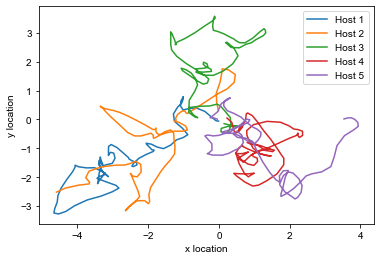

In [6]:
# Load and plot trajectories
num = 100
host_trajs = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}.csv".format(i + 1, num)) 
              for i in [0, 1, 2, 3, 4]}
host_keys = list(host_trajs.keys())
deltat = host_trajs[host_keys[0]].time.values[1] - host_trajs[host_keys[0]].time.values[0]
for i in range(5):
    plt.plot(host_trajs['h{0}'.format(i + 1)].x, host_trajs['h{0}'.format(i + 1)].y, '-', label="Host {0}".format(i + 1))
plt.xlabel("x location")
plt.ylabel("y location")
plt.legend(prop={'size': 10})

### Calculate $R_0$, individual-level $R_0$, and pairwise $R_0$ using MoveSTIR

In [7]:
T = num
pathogen_decay = 0.1
distance_decay = 0.71
β = 1.5 / ((1 / (np.pi*distance_decay**2))) # Acquisition rate (area per time)
λ = 1.5 #1.5 # Deposition rate
γ = 0.11 # Recovery rate
params = {"pathogen_decay": pathogen_decay,
          "distance_decay": distance_decay,
          "dd_type": "cutoff",
          "beta": β,
          "lambda": λ,
          "gamma": γ}

R, R0, F, U = stir.movement_R0(host_trajs, params)
R0

1.4357529036033747

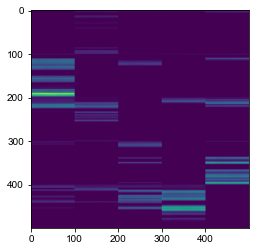

In [8]:
# Visualize the R matrix for all 5 hosts (see Appendices)
plt.imshow(R) 

Collapse the R matrix using the assumption that loss of infection probability is low over the course of the
movement trajectory (which holds for this example)

In [9]:
nhosts = len(host_keys)
collapsed_matrix = np.empty((nhosts, nhosts))
time = np.int64(R.shape[0] / nhosts)

for i in range(nhosts):
    for j in range(nhosts):
        
        Rsmall = R[i*time:(i*time + time), j*time:(j*time + time)]
        collapsed_matrix[i, j] = np.max(np.abs(np.linalg.eigvals(Rsmall)))
    

In [10]:
np.linalg.eigvals(collapsed_matrix)

array([ 1.42019151,  0.49845235, -0.12236086, -0.53199805, -1.26428495])

In [11]:
np.round(collapsed_matrix, decimals=3)

array([[0.   , 0.151, 0.012, 0.012, 0.032],
       [1.634, 0.   , 0.118, 0.004, 0.075],
       [0.372, 0.431, 0.   , 0.152, 0.285],
       [0.026, 0.004, 0.255, 0.   , 1.177],
       [0.182, 0.131, 0.629, 1.312, 0.   ]])

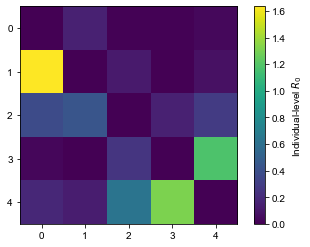

In [12]:
plt.imshow(collapsed_matrix)
cbar = plt.colorbar()
cbar.set_label("Individual-level $R_0$")

## Simulate the dynamics of the inidividual-level model

The above calculation of $R_0$ is based on an individual-level, SIS dynamic model.  Dynamic simulations of this model should yield identical information regarding invasion as our calculation of $R_0$ from the dynamic network.

In [13]:
steps = 100
len_of_season = T
initial_values = np.repeat(1e-8, 5)
sim_probs = stir.simulate_sis_model(steps, host_trajs, params, initial_values=initial_values)

Text(0, 0.5, 'log10(Probability host is infected)')

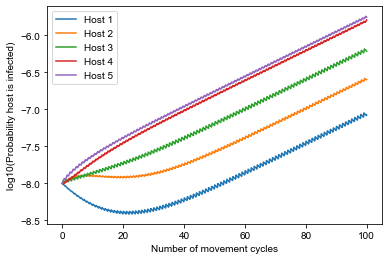

In [14]:
# Plot log trajectories
lines = plt.plot(np.arange(steps*len_of_season) / len_of_season, np.log10(sim_probs[1::2, :].T), label=['Host {0}'.format(i + 1) for i in range(5)])
plt.legend()
plt.xlabel("Number of movement cycles")
plt.ylabel("log10(Probability host is infected)")

### Make part of Figure S6 to show variability in infection trajectories over the course of the movement trajectory

Here, we can see that when $R_0 > 1$ and we are in the growth phase of the epidemic, the probability that a host is infected is higher at the end of the trajectory than at the beginning. However, the probability that a host is infected varies over the course of the movement trajectory. 

(0.85, 1.02)

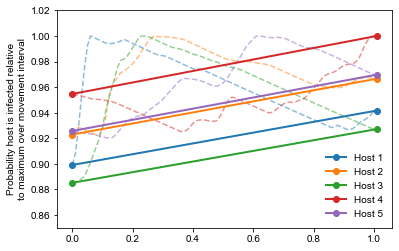

In [15]:
cycle = 80
one_cycle = sim_probs[1::2, len_of_season*cycle:(len_of_season*cycle + len_of_season + 1)]
one_cycle_norm = one_cycle / np.max(one_cycle, axis=1)[:, np.newaxis]
lines = plt.plot(np.arange(len_of_season + 1) / len_of_season, one_cycle_norm.T, alpha=0.5, ls='--')

for i in range(one_cycle_norm.shape[0]):
    plt.plot([0, (len_of_season + 1) / len_of_season], one_cycle_norm[i, [0, len_of_season]], '-o', lw=2, 
             color=sns.color_palette()[i], label="Host {0}".format(i + 1))

plt.ylabel("Probability host is infected relative\nto maximum over movement interval")
plt.legend(frameon=False)
plt.ylim(0.85, 1.02)

## Use MoveSTIR to examine the spatial sensitivity of $R_0$ to acquisition

We can use MoveSTIR to ask: In what spatial areas does spatially perturbing the kernel function have the largest effect on $R_0$? 

In [16]:
importlib.reload(stir)
num = 100
host_trajs = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}.csv".format(i + 1, num)) 
              for i in [0, 1, 2, 3, 4]}
host_keys = np.sort(list(host_trajs.keys()))
deltat = host_trajs[host_keys[0]].time.values[1] - host_trajs[host_keys[0]].time.values[0]

T = num
pathogen_decay = 0.1
distance_decay = 0.71
β = 1.5 / ((1 / (np.pi*distance_decay**2))) # acquisition rate
λ = 1.5 # deposition rate
γ = 0.11 # Recovery rate
params = {"pathogen_decay": pathogen_decay,
          "distance_decay": distance_decay,
          "dd_type": "cutoff",
          "beta": β,
          "lambda": λ,
          "gamma": γ}

# Baseline R0
R, R0, F, U = stir.movement_R0(host_trajs, params)
R0

1.4357529036033747

In [17]:
importlib.reload(stir)
bins = 20 # Number of bins across the x and y direction
delta = 0.001 # Perturbation

# Join all 
all_trajs = pd.concat(host_trajs)

minx = all_trajs.x.min() - 0.1
maxx = all_trajs.x.max() + 0.1
miny = all_trajs.y.min() - 0.1
maxy = all_trajs.y.max() + 0.1
xbounds = stir.set_discretized_values(minx, maxx, bins)
ybounds = stir.set_discretized_values(miny, maxy, bins)

# Identify which grid cells each point is in
xind, yind = stir.map_to_grid(all_trajs.x.values, all_trajs.y.values, 
                         xbounds['bnd'], ybounds['bnd'])

# Which grid cells are unique? No need to calculate multiple times
unq_ind = ~pd.DataFrame(dict(x=xind, y=yind)).duplicated().values

# Set bounds
lowerx = xbounds['bnd'][xind[unq_ind]]
upperx = xbounds['bnd'][xind[unq_ind] + 1]
xbnd = np.array(list(zip(lowerx, upperx)))
lowery = ybounds['bnd'][yind[unq_ind]]
uppery = ybounds['bnd'][yind[unq_ind] + 1]
ybnd = np.array(list(zip(lowery, uppery)))

# Calculate elasticity for all squares
elas_vals = []
for xb, yb in zip(xbnd, ybnd):
    perturb = {'xbound': xb, 'ybound': yb, 'delta': delta}
    _, R0_p, F_p, _ = stir.movement_R0(host_trajs, params, perturb=perturb)
    elas = (R0_p - R0) / (delta*R0)
    elas_vals.append(elas)

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


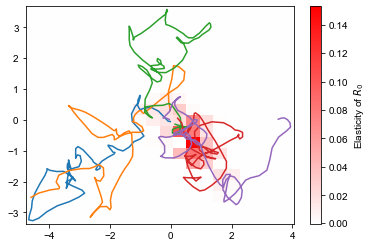

In [18]:
from matplotlib.colors import TwoSlopeNorm

# Plot host trajectories
for h in host_keys:
    plt.plot(host_trajs[h].x.values, host_trajs[h].y.values, '-', ms=5, alpha=1)

XX, YY = np.meshgrid(xbounds['bnd'], ybounds['bnd'])
ZZ = XX*YY*0

ZZ[yind[unq_ind], xind[unq_ind]] = np.abs(elas_vals)
maxval = np.max(np.abs(elas_vals))
norm = TwoSlopeNorm(vmin=-0.00001, vcenter=0, vmax=maxval)
plt.pcolormesh(XX, YY, ZZ, cmap="bwr", norm=norm)
cbar = plt.colorbar()
cbar.set_label("Elasticity of $R_0$")


## Remove individuals and recalculate R0

In [19]:
num = 100
all_hosts = np.arange(len(host_keys))

removehost_R0 = []

for host_drop in all_hosts:
    
    new_hosts = all_hosts[all_hosts != host_drop]
    host_trajs_new = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}.csv".format(i + 1, num)) 
                  for i in new_hosts}
    host_keys_new = np.sort(list(host_trajs_new.keys()))
    deltat = host_trajs_new[host_keys_new[0]].time.values[1] - host_trajs_new[host_keys_new[0]].time.values[0]

    T = num
    pathogen_decay = 0.1
    distance_decay = 0.71
    β = 1.5 / ((1 / (np.pi*distance_decay**2)))# acquisition rate
    λ = 1.5 # deposition rate
    γ = 0.11 # Recovery rate
    params = {"pathogen_decay": pathogen_decay,
              "distance_decay": distance_decay,
              "dd_type": "cutoff",
              "beta": β,
              "lambda": λ,
              "gamma": γ}
    # New R0
    removehost_R0.append(stir.movement_R0(host_trajs_new, params)[1])

perturb_R0 = (R0 - np.array(removehost_R0)) / R0


In [20]:
perturb_R0

array([0.01501716, 0.02154682, 0.11549779, 0.48928446, 0.58412139])

### Combine all of the results together and plot

This replicates Figure S6 in the manuscript

/Users/mqwilber/opt/anaconda3/envs/moveSTIR/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


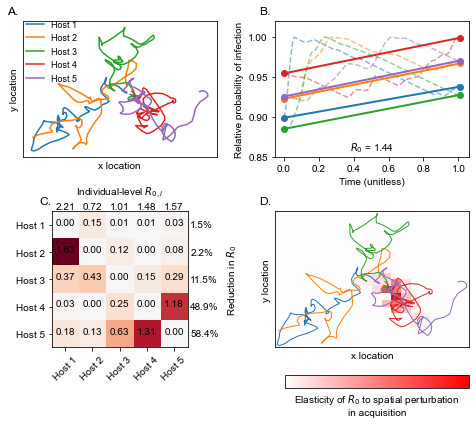

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()

# Plot all host trajectories
for i, h in enumerate(host_keys):
    axes[0].plot(host_trajs[h].x.values, host_trajs[h].y.values, '-', alpha=1, label='Host {0}'.format(i + 1))
axes[0].legend(loc=(0, 0.52), frameon=False, prop={'size': 9})
axes[0].tick_params(bottom=None, left=None, labelbottom=None, labelleft=None)
axes[0].set_xlabel("x location")
axes[0].set_ylabel("y location")



cycle = 80
one_cycle = sim_probs[1::2, len_of_season*cycle:(len_of_season*cycle + len_of_season + 1)]
one_cycle_norm = one_cycle / np.max(one_cycle, axis=1)[:, np.newaxis]
lines = axes[1].plot(np.arange(len_of_season + 1) / len_of_season, one_cycle_norm.T, alpha=0.5, ls='--')
for i in range(one_cycle_norm.shape[0]):
    axes[1].plot([0, (len_of_season + 1) / len_of_season], one_cycle_norm[i, [0, len_of_season - 1]], '-o', lw=2, 
             color=sns.color_palette()[i], label="Host {0}".format(i + 1))

axes[1].set_ylabel("Relative probability of infection")
axes[1].text(0.5, .05, "$R_0$ = {0:.2f}".format(R0), ha='center', transform=axes[1].transAxes)
axes[1].set_xlabel("Time (unitless)")
axes[1].set_ylim(0.85, 1.02)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

maxval = np.max(collapsed_matrix)
norm = TwoSlopeNorm(vmin=-0.00001, vcenter=0, vmax=maxval)
axes[2].imshow(collapsed_matrix, cmap="RdBu_r", norm=norm )
axes[2].set_xticks(np.arange(5))
axes[2].set_yticks(np.arange(5))
axes[2].set_xticklabels(['Host {0}'.format(i + 1) for i in range(5)], rotation=45)
axes[2].set_yticks(np.arange(5))
axes[2].set_yticklabels(['Host {0}'.format(i + 1) for i in range(5)])
for i in range(5):
    for j in range(5):
        axes[2].text(i, j, "{0:.2f}".format(collapsed_matrix[j, i]), ha='center')

# Plot R0 estimates
for i in range(5):
    axes[2].text(i, -.6, "{0:.2f}".format(collapsed_matrix[:, i].sum()), ha='center')
    axes[2].text(4.6, i, "{0:.1f}%".format(perturb_R0[i]*100), ha='left', va='center')

axes[2].text(0.5, 1.12, "Individual-level $R_{0, i}$", ha='center', transform=axes[2].transAxes)
axes[2].text(1.28, 0.5, "Reduction in $R_{0}$", va='center', rotation=90, transform=axes[2].transAxes)
    
# Plot host trajectories
for h in host_keys:
    axes[3].plot(host_trajs[h].x.values, host_trajs[h].y.values, '-', linewidth=1, alpha=1)

XX, YY = np.meshgrid(xbounds['bnd'], ybounds['bnd'])
ZZ = XX*YY*0

ZZ[yind[unq_ind], xind[unq_ind]] = np.abs(elas_vals)
maxval = np.max(np.abs(elas_vals))
norm = TwoSlopeNorm(vmin=-0.00001, vcenter=0, vmax=maxval)
pcol = axes[3].pcolormesh(XX, YY, ZZ, cmap="bwr", norm=norm)

cax = fig.add_axes([0.58, .03, 0.32, 0.03])
cbar = fig.colorbar(pcol, cax=cax, orientation='horizontal', ticks=[0, 0.05, 0.1])
cbar.set_label("Elasticity of $R_0$ to spatial perturbation\nin acquisition")
cbar.ax.tick_params(axis='x', bottom=None, labelbottom=None)

axes[3].tick_params(bottom=None, left=None, labelbottom=None, labelleft=None)
axes[3].set_xlabel("x location")
axes[3].set_ylabel("y location")

letters = ["A.", "B.", "C.", "D."]
for i, ax in enumerate(axes):
    ax.text(-0.05, 1.05, letters[i], size=12, ha='center', transform=ax.transAxes)
    
# fig.savefig("../results/five_host_example.pdf", bbox_inches="tight")

## Comparing static and dynamic networks

MoveSTIR can also be used to define and explore network static and dynamic networks defined by the host movement trajectories.  Here, we show how you can define weighted static networks and dynamic contact networks using MoveSTIR. 

In [120]:
num = 100
host_trajs = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}.csv".format(i + 1, num)) for i in [0, 1, 2, 3, 4]}
host_keys = np.sort(list(host_trajs.keys()))
deltat = host_trajs[host_keys[0]].time.values[1] - host_trajs[host_keys[0]].time.values[0]

T = num
pathogen_decay = 0.1
distance_decay = 0.71
β = 2.376 # acquisition rate
λ = 1.5 # deposition rate
γ = 0.11 # Recovery rate
params = {"pathogen_decay": pathogen_decay,
          "distance_decay": distance_decay,
          "dd_type": "cutoff",
          "beta": β,
          "lambda": λ,
          "gamma": γ}

In [121]:
# Calculate the Average FOI felt by each pair of hosts. Average FOI is defined in Table 1

host_keys = list(host_trajs.keys())
avg_foi = np.zeros((len(host_keys), len(host_keys)))

for i, h1 in enumerate(host_keys):
    for j, h2 in enumerate(host_keys):
        
        if i != j:
            deltat, K_ilagj, dmat = stir.transmission_kernel(host_trajs[h1], host_trajs[h2], 
                                                             pathogen_decay, distance_decay, 
                                                             dd_type="cutoff")
            foi = np.sum(β * λ * (K_ilagj*deltat*deltat).sum(axis=1)) / 1.0 # Time period
            avg_foi[i, j] = foi   

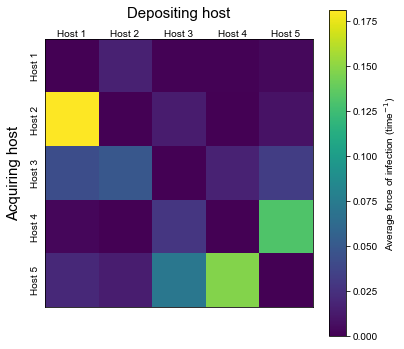

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cmap = ax.imshow(avg_foi)
cbar = plt.colorbar(cmap)
cbar.set_label("Average force of infection (time$^{-1}$)")

ax.tick_params(bottom=None, left=None, labelbottom=None, labelleft=None)

for i, nt in enumerate(np.arange(5)):
    ax.text(nt, -0.55, "Host {0}".format(i + 1), ha='center')
    ax.text(-.75, nt, "Host {0}".format(i + 1), va='center', rotation=90)
    if i == 2:
        ax.text(nt, -.9, "Depositing host", ha='center', size=15)
        ax.text(-1.2, nt, "Acquiring host", va='center', size=15, rotation=90)
        
# fig.savefig("../results/static_matrix.pdf", bbox_inches="tight")

Text(0, 0.5, 'y location')

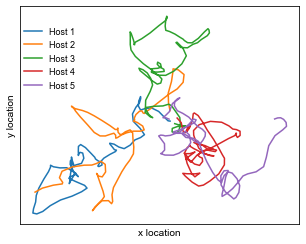

In [123]:
# Plot and save all host trajectories for reference
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Plot all host trajectories
for i, h in enumerate(host_keys):
    ax.plot(host_trajs[h].x.values, host_trajs[h].y.values, '-', alpha=1, label='Host {0}'.format(i + 1))
ax.legend(loc=(0, 0.6), frameon=False, prop={'size': 9})
ax.tick_params(bottom=None, left=None, labelbottom=None, labelleft=None)
ax.set_xlabel("x location")
ax.set_ylabel("y location")

# fig.savefig("../results/five_hosts.pdf", bbox_inches="tight")

### Graphing the direct and indirect contact network

Once we have used MoveSTIR to define the contact network, we can use standard network tools to plot and explore the network.  We will demonstrate using `igraph`.

In [124]:
import igraph as ig
g = ig.Graph.Weighted_Adjacency(avg_foi.T)
edge_weights = avg_foi.T[np.where(avg_foi.T > 0)]

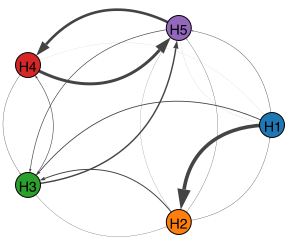

In [125]:
ig.plot(g, #"../results/static_weighted.pdf", 
        layout="circular",
            edge_width=(edge_weights)*20,
            edge_arrow_size=edge_weights*8,
            vertex_size=25,
            vertex_color=sns.color_palette()[:5],
            vertex_label=['H{0}'.format(i) for i in range(1, 6)],
            bbox=(0, 0, 300, 250), margin=28)

Use MoveSTIR to compute the epidemiological metrics such as $R_0$ on the static network defined above.  How do they compare to the dynamic network?  Does it yield significantly different answers?

In [126]:
import importlib
importlib.reload(stir)

# R0 from the static network, assuming continuous time
R_avg, R0_avg, F_avg, U_avg = stir.movement_R0_from_avg_foi(avg_foi, γ)

# Same calculation using a discrete-time approximation
F_discrete = F_avg*deltat
U_discrete = U_avg.astype(np.float64)
U_discrete[np.diag_indices_from(U_discrete)] = np.exp(U_avg[np.diag_indices_from(U_avg)] * deltat)
one_minus_U_inv = np.linalg.inv((np.eye(U_discrete.shape[0]) - U_discrete))
R0_discrete = np.max(np.abs(np.linalg.eigvals(np.dot(F_discrete, one_minus_U_inv))))

# Full dynamic network
R_full, R0_full, F_full, U_full = stir.movement_R0(host_trajs, params)

In [127]:
print((R0_avg, R0_discrete, R0_full))

(1.4520352769992122, 1.452842112650505, 1.4360458636007059)


The static and dynamic network are yielding very similar predictions regarding $R_0$.  This equivalence starts to break down as loss of infection rate becomes larger relative to the length of the movement trajectory.

## Visualize the temporal network

First, let's visualize the transmission kernel for the five host example

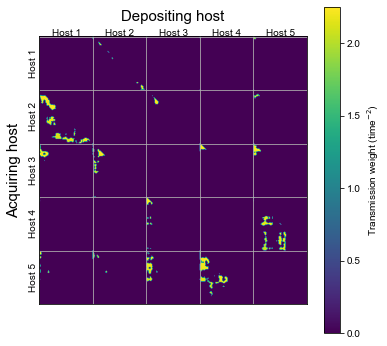

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cmap = ax.imshow(F_full / deltat)
ticks = np.linspace(0, (num*len(host_keys)) , num=len(host_keys) + 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
cbar = plt.colorbar(cmap)
cbar.set_label("Transmission weight (time$^{-2}$)")
ax.grid()

new_ticks = np.linspace(num / 2, (num*len(host_keys)) - (num / 2) , num=len(host_keys))
ax.tick_params(bottom=None, left=None, labelbottom=None, labelleft=None)

for i, nt in enumerate(new_ticks):
    ax.text(nt, -1, "Host {0}".format(i + 1), ha='center')
    ax.text(-20, nt, "Host {0}".format(i + 1), va='center', rotation=90)
    if i == 2:
        ax.text(nt, -30, "Depositing host", ha='center', size=15)
        ax.text(-60, nt, "Acquiring host", va='center', size=15, rotation=90)

# fig.savefig("../results/dynamic_matrix.pdf", bbox_inches="tight")

Note that each grid is a pairwise transmission kernel and these pairwise kernels are "glued" together to form the full transmission matrix.

---

To simplify the network visualization, simulate equivalent movement trajectories with only 10 time steps. You can do that by adjusting `n` to `n = 10` in the simulation code given above.  We then plot a simplified version of the dynamic network with ten time steps spanning the entire 1 unit movement trajectory.

In [131]:
# FMM parameters
tlower = 0 # Start time
tupper = 1 # End time
n = 10 # Number of observed points
m = 850 # Number of points at which to approximate the integral. See Hooten and Johnson 2017
σ_measure = 0 # No measurement error
σ_process = .1 # White noise variability
deltat = 1 
ϕ_H = 0.01 # As sigma H goes to zero, you get Brownian motion

nvals = stir.set_discretized_values(0, 1, n)['y'] 

# Set random seed for reproducibility
rint = 61
np.random.seed(rint)
for i in range(5):
    # Simulate and save movement trajectories
    sim = stir.simulate_movement(nvals, m, σ_process, σ_measure, ϕ_H, init_position=np.array([0, 0]))
    
    # Setting trajectory names to match example
    if i == 2:
        sim.to_csv("host{0}_example_n={1}.csv".format(i + 2, n), index=False)
    elif i == 3:
        sim.to_csv("host{0}_example_n={1}.csv".format(i, n), index=False)
    else:
        sim.to_csv("host{0}_example_n={1}.csv".format(i + 1, n), index=False)

In [132]:
num = 10
host_trajs = {'h{0}'.format(i + 1): pd.read_csv("host{0}_example_n={1}.csv".format(i + 1, num)) for i in [0, 1, 2, 3, 4]}
host_keys = np.sort(list(host_trajs.keys()))
deltat = host_trajs[host_keys[0]].time.values[1] - host_trajs[host_keys[0]].time.values[0]

T = num
pathogen_decay = 0.1
distance_decay = 0.71
β = 2.376 # acquisition rate
λ = 1.5 # deposition rate
γ = 0.11 # Recovery rate
params = {"pathogen_decay": pathogen_decay,
          "distance_decay": distance_decay,
          "dd_type": "cutoff",
          "beta": β,
          "lambda": λ,
          "gamma": γ}

# Calculate R0 to get the transmission matrix which we will use to plot the dynamic network
R, R0, F, U = stir.movement_R0(host_trajs, params)

In [133]:
# For plotting, add within-host connections
avg_val = F[F > 0].mean()
for i in range(len(host_trajs)):
    
    Ftemp = F[i*num:((i + 1)*num), i*num:((i + 1)*num)]
    row, col = np.diag_indices(Ftemp.shape[0])
    row_up = (row + 1)[:-1]
    col_up = col[:-1]
    Ftemp[(row_up, col_up)] = avg_val
    Ftemp[0, -1] = avg_val
    F[i*num:((i + 1)*num), i*num:((i + 1)*num)] = Ftemp

In [134]:
# Define the igraph
gfull = ig.Graph.Weighted_Adjacency(F.T)

In [135]:
def vertical_layout(time, hosts, seph=2, sepv=0):
    """
    Custom layout for the dynamic network
    """
    coords = []
    counth = 0
    for h in range(hosts):
        countv = 0
        for t in range(time):
            
            if (t == 0) or (t == (time  - 1)):
                back = 1
            else:
                back = 0
#             back = 0
            coords.append((h + counth - back, t + countv))
            countv += sepv
        counth = counth + seph
    return(coords)

layout = ig.Layout(vertical_layout(num, len(host_keys), seph=2))

In [136]:
weights = gfull.get_edge_dataframe().weight.values / deltat

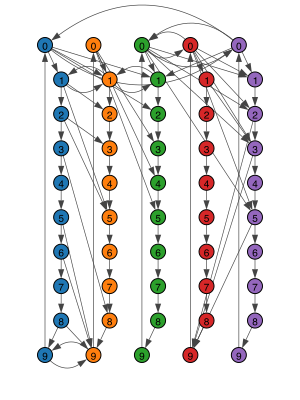

In [137]:
nested_colors = [sns.color_palette()[i:(i + 1)]*num for i in range(len(host_keys))]
vcolors = [item for subitem in nested_colors for item in subitem]

ig.plot(gfull, #"../results/dynamic_weighted.pdf", 
        layout=layout,
        vertex_size=15,
        vertex_color=vcolors,
        edge_width=(weights)*0.3,
        edge_arrow_size=weights*0.3,
        vertex_label=np.tile(np.arange(num), len(host_keys)),
        vertex_label_size=10, 
        margin=45, bbox=(0, 0, 300, 400))